In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Load the dataset
data = pd.read_csv('../Weather/merged_weather_tyre_data_2019.csv')
data = data.sample(frac=0.50, random_state=42).reset_index(drop=True)

# Define features and target
X = data[['AirTemp', 'Humidity', 'Rainfall', 'TrackTemp', 'GP', 'Lap']]
y = data['Tyres']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
imputed_values = imputer.fit_transform(X[['AirTemp', 'Humidity', 'Rainfall', 'TrackTemp', 'Lap']])
# Convert imputed values to a DataFrame with the same columns and index
imputed_df = pd.DataFrame(
    imputed_values,
    columns=['AirTemp', 'Humidity', 'Rainfall', 'TrackTemp', 'Lap'],
    index=X.index
)

# Cast each column to its original dtype
for col in ['AirTemp', 'Humidity', 'Rainfall', 'TrackTemp', 'Lap']:
    imputed_df[col] = imputed_df[col].astype(X[col].dtype)

# Assign back to the DataFrame
X.loc[:, ['AirTemp', 'Humidity', 'Rainfall', 'TrackTemp', 'Lap']] = imputed_df



# Drop rows where 'Tyres' is missing
X = X.dropna()
y = y.loc[X.index]

# One-hot encode the categorical column 'GP'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(
    encoder.fit_transform(X[['GP']]),
    columns=encoder.get_feature_names_out(['GP']),
    index=X.index  # Ensure index alignment
)
# Add one-hot encoded columns to X and drop the original 'GP' column
X = pd.concat([X.drop(columns=['GP']), X_encoded], axis=1)

# Standardize features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(X.iloc[:, :-len(X_encoded.columns)])
scaled_columns = pd.DataFrame(
    scaled_values,
    columns=X.columns[:-len(X_encoded.columns)],
    index=X.index
)
X.loc[:, scaled_columns.columns] = scaled_columns.astype(X[scaled_columns.columns].dtypes.to_dict())


# Reset indices to ensure alignment between X and y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers with improvements
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")
    print("-" * 50)


KeyboardInterrupt: 

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train and evaluate XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("Model: XGBoost")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred, zero_division=1)}")


NameError: name 'y_train' is not defined

In [6]:
# Calculate class weights for each class
import numpy as np

class_counts = np.bincount(y_train_encoded)
scale_pos_weights = [len(y_train_encoded) / (len(class_counts) * count) for count in class_counts]

# Train XGBoost with class weights
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weights
)
xgb_model.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("Model: XGBoost with Class Weights")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred, zero_division=1)}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:06:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost with Class Weights
Accuracy: 0.4753127535420601
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.61      0.57    135785
           1       1.00      0.00      0.00     16610
           2       0.65      0.41      0.50     28424
           3       0.16      0.00      0.00      1825
           4       0.44      0.72      0.55    191469
           5       0.48      0.13      0.21     54664
           6       0.43      0.07      0.11     48449
           7       0.44      0.30      0.36     80095
           8       0.47      0.20      0.28      7181

    accuracy                           0.48    564502
   macro avg       0.51      0.27      0.29    564502
weighted avg       0.49      0.48      0.43    564502



In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'learning_rate': [0.4, 0.8],         # Remove higher values like 0.2 if unnecessary
    'max_depth': [7, 8],                 # Focus on fewer depth levels
    'n_estimators': [150, 250],           # Smaller range of estimators
    'min_child_weight': [1, 4]           # Remove less impactful values
}
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1,
    refit= True
)
random_search.fit(X_train, y_train_encoded)

# Best parameters
print(f"Best Parameters: {random_search.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:06:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.8, max_depth=8, min_child_weight=4, n_estimators=150; total time=  47.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:06:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.8, max_depth=8, min_child_weight=4, n_estimators=150; total time=  48.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:07:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.8, max_depth=8, min_child_weight=4, n_estimators=150; total time=  46.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:08:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'n_estimators': 150, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.8}


In [2]:
# Train the final XGBoost model
final_xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=150,
    min_child_weight=1,
    max_depth=7,
    learning_rate=0.45
)
final_xgb_model.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_final = final_xgb_model.predict(X_test)

# Classification report
print("Final XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_final)}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred_final, zero_division=1)}")


NameError: name 'XGBClassifier' is not defined

In [20]:
# Access the best model
best_model = random_search.best_estimator_

# Predict using the best model
y_pred_final = best_model.predict(X_test)
print(f"Final Model Accuracy: {accuracy_score(y_test_encoded, y_pred_final)}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred_final)}")


Final Model Accuracy: 0.30573673786806776
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.26      0.29    135785
           1       0.04      0.04      0.04     16610
           2       0.30      0.34      0.32     28424
           3       0.02      0.02      0.02      1825
           4       0.38      0.49      0.43    191469
           5       0.21      0.18      0.19     54664
           6       0.15      0.10      0.12     48449
           7       0.26      0.20      0.23     80095
           8       0.13      0.27      0.17      7181

    accuracy                           0.31    564502
   macro avg       0.20      0.21      0.20    564502
weighted avg       0.29      0.31      0.30    564502



In [ ]:
# Cross-validation for robustness with parallel processing
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"Cross-validation scores for {name}: {scores}")
    print(f"Mean CV Accuracy: {scores.mean()}")
    print("-" * 50)


In [1]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(final_xgb_model, max_num_features=4)
plt.title("Top 10 Feature Importances")
plt.show()


NameError: name 'final_xgb_model' is not defined

<Figure size 1000x800 with 0 Axes>

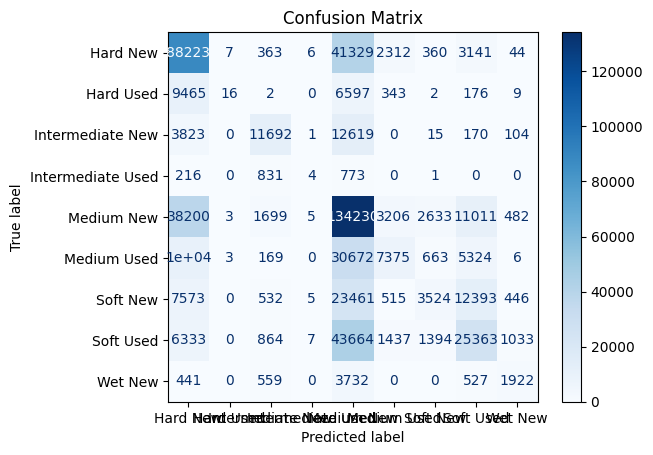

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(final_xgb_model, X_test, y_test_encoded, display_labels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


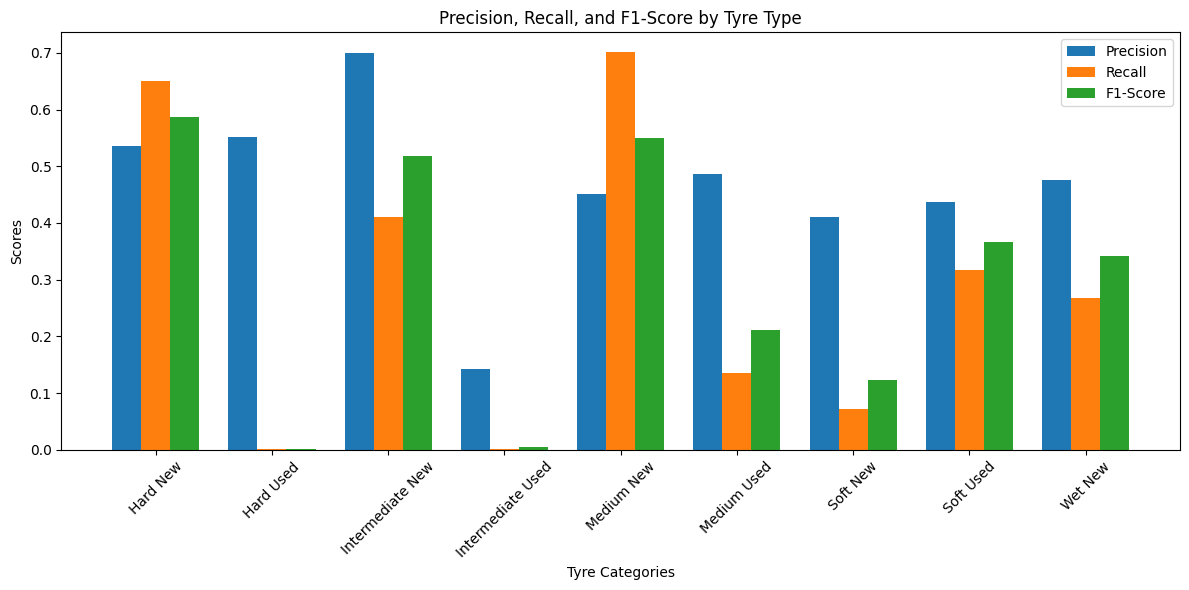

In [24]:
import numpy as np

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(y_test_encoded, y_pred_final, target_names=label_encoder.classes_, output_dict=True)

# Extract precision, recall, and F1-score for each class
classes = list(report.keys())[:-3]  # Exclude avg/total metrics
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Bar chart
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.xlabel('Tyre Categories')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score by Tyre Type')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


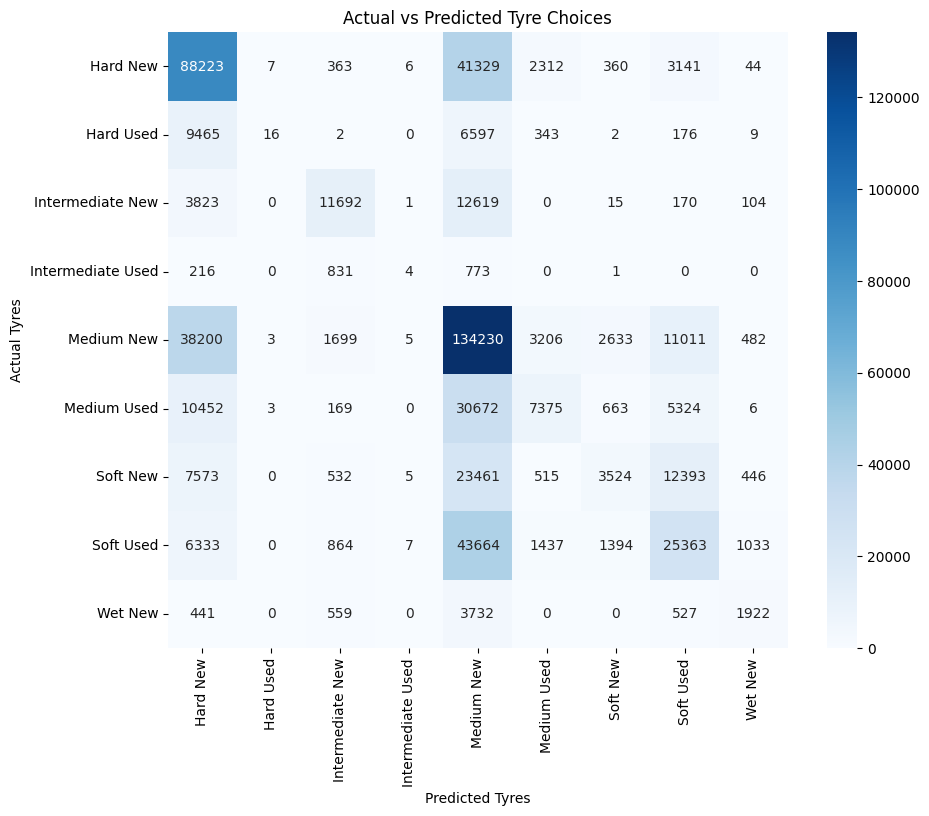

In [25]:
import seaborn as sns
import pandas as pd

# Create a DataFrame with actual vs. predicted values
results_df = pd.DataFrame({
    'Actual': label_encoder.inverse_transform(y_test_encoded),
    'Predicted': label_encoder.inverse_transform(y_pred_final)
})

# Pivot table for heatmap
heatmap_data = results_df.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title("Actual vs Predicted Tyre Choices")
plt.xlabel("Predicted Tyres")
plt.ylabel("Actual Tyres")
plt.show()
